# Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The below can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


# Performing Sharpe Style Analysis

The key to obtaining the weights is, the quadriatic optimizer. We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

# Analyzing Style Tilts of Motilal Oswal S&P 500 Index fund Direct-Growth

# Motilal_Oswal S&P 500 Index Fund Direct-Growth.



Did the small practice to find out the style tilts of the above fund. And how much "alpha" the fund generated for the period.

*Sample bias can be a limitation of this analysis*



#Data

3-year monthly data of SPDR Portfolio S&P 500 Growth ETF (SPYV).

3-year monthly data of SPDR Portfolio S&P 500 Value ETF (SPYG).

3-year monthly data of SPDR S&P 600 Small Cap ETF (SPY).

3-year monthly data of i-shares S&P 100 ETF (OEF)[Large cap ETF]

3-year monthly data of Motilal_Oswal S&P 500 Index Fund Direct (MO)



#EQUATION

MO= w1*SPYV+w2* SPYG+w3*SPY+w4*OEF



Ran the optimizer function in such a way, that it gives the weights in each style in a manner that minimizes the tracking error between the weighted style portfolio returns and our fund returns.



The key to obtaining the weights is the #quadratic optimizer. We are asking the optimizer to find the weights that minimize the square of the difference between the fund return series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.



Then regression was performed to find out the alpha of the fund, if any.



#Results.

The fund has:

49.08% Value-exposure,

48.84% Growth-exposure, 

2.07% Small-Cap exposure,

0.00& Large-Cap exposure.

The "alpha" generated was 0.51% relative to the above benchmark-style ETFs.



In [69]:
import numpy as np
import pandas as pd

import motilal_risk_kit as mrk
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
explanatory_variables=pd.read_csv("Motilal_explanatory_variables.csv", header=0, index_col=0,parse_dates=True)
explanatory_variables.index = pd.to_datetime(explanatory_variables.index, format="%Y%m").to_period('M')

explanatory_variables    

,SPYV,SPYG,SLY,OEF
2020-06,-0.018293,0.038613,0.033625,0.023794
2020-07,0.046467,0.073548,0.046253,0.060846
2020-08,0.034208,0.094406,0.039350,0.089170
2020-09,-0.030186,-0.047881,-0.047716,-0.049964
2020-10,-0.011710,-0.028242,0.025507,-0.027799
2020-11,0.128456,0.096934,0.183218,0.101937
2020-12,0.027487,0.037336,0.078509,0.033042
2021-01,-0.009789,-0.002134,0.066499,-0.000948
2021-02,0.059657,-0.000363,0.078371,0.013292
2021-03,0.056299,0.025082,0.031727,0.039179


In [90]:
Motilal_returns= pd.read_csv("Motilal_Fund.csv", header=0, index_col=0,parse_dates=True).dropna()
Motilal_returns.index = pd.to_datetime(Motilal_returns.index, format="%Y%m").to_period('M')




In [74]:
def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

In [75]:
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

In [80]:
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights

In [87]:
import statsmodels.api as sm
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which we can call
       .summary() to print a full summary
       .params for the coefficients
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1
    
    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm

In [85]:
weights=style_analysis(Motilal_returns["Motilal Fund"], explanatory_variables)*100
weights


SPYV    49.080732
SPYG    48.845288
SLY      2.073981
OEF      0.000000
dtype: float64

<Axes: >

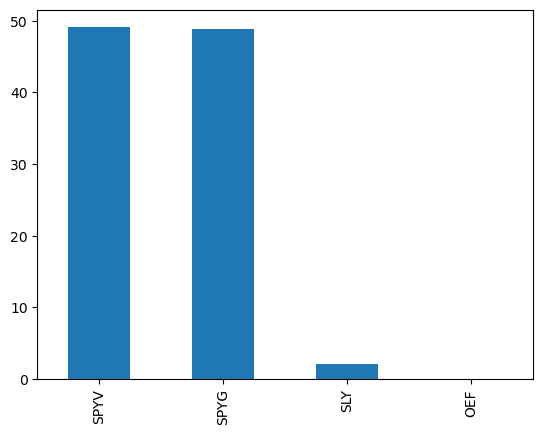

In [86]:
weights.sort_values(ascending=False).head(6).plot.bar()

In [89]:
coeffs = regress(Motilal_returns["Motilal Fund"], explanatory_variables).params*100
coeffs.sort_values().head()

OEF     -66.663040
Alpha     0.518874
SLY       6.751999
SPYV     35.955371
SPYG     89.941392
dtype: float64